# El Niño in the recharge oscillator paradigm

In the lab, we investigate the dynamics of ENSO via a simple model for ENSO, called the "recharge oscillator". We will investigate 3 phenomena:
    1. linear stability
    2. nonlinear effects 
    3. frequency-locking

First, some background:

## An equatorial ocean recharge paradigm for ENSO
The following theory closely follows (in places, paraphrases) the seminal work of [Jin [1997a,b]]:

Jin, F.-F. (1997), An equatorial ocean recharge paradigm for enso. 
part i: Conceptual model, Journal of the Atmospheric Sciences, 54(7), 
811–829, doi:10.1175/1520-0469(1997)054¡0811:AEORPF¿2.0.CO;2.


### main idea
ENSO is an interplay between a fast, positive feedback (the Bjerknes feedback, involving mutually-reinfocings interactions between the ocean and the atmospehre) and slow ocean adjustment processes via long, low-frequency Kelvin and Rossby waves reflected in thermocline depth (hence, in sea-level). The east-west tilt of the thermocline rapidly adjusts to zonal winds, but the mean depth of the thermocline takes much, much longer to adjust.  Surface temperature (SST) is affected by these variations in thermocline depth, as it controls the temperature of the water upwelling in the Cold Tongue region of the Eastern equatorial Pacific. In turn, Cold Tongue SST has a stronge effect on atmospheric circulation, which then feedback on thermocline depth via surface winds and the ocean waves they excite. 

This disparity of timescales and the coupling between these various components sets the stage for regular and irregular oscillations, damped or self-sustained (depending on parameter values). It is thus a useful model to understand the role of various parameters and processes. 

### Thermocline depth equation 

$$ \frac{d h_W}{dt} = -r h_W - F_\tau $$

This equation focuses on the thermocline depth changes averaged over the western equatorial Pacific during the basinwide adjustment because the tropical wind anomaly associated with ENSO is largely over the western to central Pacific (Deser and Wallace 1990). The first term on the right-hand side represents the ocean adjustment. It is simply characterized by a damping process with a rate $r$ that collectively represents the damping of the upper ocean system through mixing and the equatorial energy loss to the boundary layer currents. The wind forcing $F_\tau$􏰛 is related to the zonally integrated wind stress and its curl. To a large extent F􏰛 is also proportional to 􏰛the equatorial wind stress $\tau$, that is, $F_\tau = \alpha \tau$. 

The atmospheric response to a warm SST anomaly of the central to eastern Pacific is a westerly wind over the central to western equatorial Pacific and an easterly anomaly to the east of the SST anomaly. There is an overall westerly (easterly) anomaly for a positive (negative) SST anomaly averaged over the entire basin of the equatorial band, but a much weaker westerly (easterly) anomaly averaged over the eastern half of the basin (e.g., Deser and Wallace 1990). This allows the simple approximate relations of the wind stress and SST anomalies in the east, $T_E$: $ \tau = b T_E $. Clearly, the larger $b$, the larger a given SST anomaly wil be able to generate westerly wind ano=malies (i.e. weakening of the climatological Trade Winds), so $b$ measures the strength of ocean-atmosphere coupling. 


### SST equation 

The variation of SST during ENSO is largely confined within the central to eastern equatorial Pacific. The SST anomaly in this region strongly depends on the local thermocline depth that determines the temperature of the subsurface water, because this water is pumped up into the surface layer to control the SST by the climatological upwelling associated with the climatological trade wind along the equator. Changes in the trade wind intensity in response to the SST anomaly may also further reinforce the SST anomaly by altering upwelling and horizontal advection. The mean climatological upwelling and heat exchange between the atmosphere and ocean tend to damp out the SST anomaly with a rate $c$. Although the details of all these processes can be complicated, they can be roughly depicted in a simple equation for the SST anomaly $T_E$, averaged over the central to eastern equatorial Pacific:

$$ \frac{d T_E}{dt} = R T_E + \gamma h_W  $$

where $R=\gamma b - c > 0 $ measures the strength of the Bjerknes feedback. It is more than just $b$, because there is an efficiency factor $\gamma <1 $ to how upwelled water affects SST (in other words, SST balance involves more than just upwelling), 
We further define $b = b_0 * \mu$ where $b_0$ is a characteristic coupling coefficient and $\mu$ is an *effective* coupling coeffcient of order one.

### Coupled model

So the system of equations is 

$ \begin{equation}
\frac{d T_E}{dt} = R T_E + \gamma h_W \\  \end{equation}$
$ \begin{equation}
\frac{d h_W}{dt} = -r h_W - \alpha b T_E
\end{equation}$

At this point, you may wonder about units for these various quantities. It is customary to **non-dimensionalize** the system so every variable is commensurate to the others. Jin [1997a] considered scales of [h] 􏰃= 150 m, [T] = 􏰃7.5
K, and [t] = 2 months for anomalous thermocline depth, SST, and the time variable, respectively. Accordingly,
parameters c, r, and 􏰍 are scaled by $[t]^{-1}$, and parameters \gamma and b by $[h][t]/[T]$ and $[T]/[h]$. Their nondimensional values are $c=1,\gamma=0.75,r=0.25,\alpha=0.125$,and $b_0= 2.5$.


We are now finally ready to work with these equations.

## Linear stability analysis

Jin [1997a] performs a so-called linear stabikity analysis of this system to determine whether unstable (growing) modes exist, and if so, for what parameter values.  I won't put you through that, since it's a little involved, so let's experiment numerically. First, let's load some useful Python packages:

In [1]:
%matplotlib inline
import numpy as np
from scipy import integrate
import nitime.algorithms as tsa
import nitime.utils as utils
from nitime.viz import winspect
from nitime.viz import plot_spectral_estimate
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_palette("Dark2")  

# define model parameters
Tscale = 7.5 # in Kelvins
tscale = 1/6.0  # in years [=2 months]
hscale = 150.0 # in meters

Now, let's define the model itself. For reasons that wil be clear later, we'll include a couple of extra bells and whistles, which we'll ignore for now. 

In [2]:
def recharge_deriv(T_h_tuple ,t, mu, en, c = 1.0,r= 0.25,alpha = 0.125, b0 = 2.5, gamma = 0.75):
    """Compute the time-derivative of the recharge system system."""
    b = b0*mu # coupling coefficient     
    R = gamma*b-c;  #Bjerknes coefficient
    
    return [R*T_h_tuple[0] + gamma*T_h_tuple[1] - en*(T_h_tuple[1] + b*T_h_tuple[0])**3, -r*T_h_tuple[1] - alpha*b*T_h_tuple[0]]    

In [3]:
def recharge_solver(mu=0.7,en=0,x0 = [[0.1,-0.1]],max_time=500*6):    
    t = np.linspace(0, max_time, int(4*max_time)) #0부터 3000까지 12000개로쪼갬 dt=0.25=1/4
    x_t = np.asarray([integrate.odeint(recharge_deriv, x0i, t, (mu, en))
                      for x0i in x0])
    return t, x_t

Now let's define a solver for this system, and a way to plot its output 

In [21]:
def recharge_plotter(t,x_t,mu,en,x0,last_time):       
    T = x_t[0,:,0]; h = x_t[0,:,1]
    print("T",T)
    print("h",h)
    ts = t*tscale  
    print("ts",ts)
    print("last_time", last_time)
    # obtain spectrum
    f_T, S_T, nu = tsa.multi_taper_psd(T,Fs=24.0)
    # compute average period
    DominantPeriod =  "{:4.2f}".format(1/f_T[np.argmax(S_T)])  
    # plot
    plt.close('all')  
    fig = plt.figure(figsize=(8,8))
    
    # plot traces
    ax1 = plt.subplot2grid((2, 2), (0, 0),colspan = 2)
    #hdl = ax1.plot(ts[-last_time:],T[-last_time:],ts[-last_time:],h[-last_time:])
    #hdl = ax1.plot(ts,T,ts,h)
    hdl = ax1.plot(ts[:last_time],T[:last_time],ts[:last_time],h[:last_time])
    
    
    ax1.legend(hdl,[r'$T_E$',r'$h_W$'],loc = 'upper left')
    ax1.set_title(r'Recharge oscillator solution, $\mu$ = %s, $e_n$ = %s'%(mu, en),fontsize=14)
    
    # phase portrait
    ax2 = plt.subplot2grid((2, 2), (1, 0))
    ax2.plot(x_t[0,:,0],x_t[0,:,1])
    ax2.plot(x0[0][0],x0[0][1],'ro')
    ax2.set_xlabel(r'$T_E$'); ax2.set_ylabel(r'$h_W$')
    ax2.set_title("Phase portrait",fontsize=14)
    # 
    ax3 = plt.subplot2grid((2, 2), (1, 1))
    ax3.loglog(f_T,S_T, label=r'$T_E$',color='black')
    ax3.legend()
    ax3.set_title(r'Spectrum, main peak @ %s years'%DominantPeriod,fontsize=14)
    ax3.set_xlabel(r'Period (Years)'); ax3.set_xlim([1e-2,6.0])
    ax3.set_ylabel(r'PSD')
    per = [50,20,10,5,2,1,0.5]
    xt = 1.0/np.array(per)
    ax3.set_xticks(xt)
    ax3.set_xticklabels(map(str, per))


We are now ready to start tinkering around. The analysis by *Jin* [1997a] identifies $\mu_c = 2/3$ as the critical coupling coefficient.  Below this value, the system should be damped, and above, it should be unstable. Right at criticality, one should observe another remarkable phenomenon.

### What happens just below this value? 
set $\mu = 0.65$ and watch what happens by executing the next cell.

T [1.00000000e-01 8.64785650e-02 7.25367859e-02 ... 1.83055024e-16
 1.82991174e-16 1.82927325e-16]
h [-1.00000000e-01 -9.85295034e-02 -9.64716234e-02 ...  3.98943572e-16
  3.98799804e-16  3.98656035e-16]
ts [0.00000000e+00 4.16701392e-02 8.33402784e-02 ... 4.99916660e+02
 4.99958330e+02 5.00000000e+02]
last_time 2400


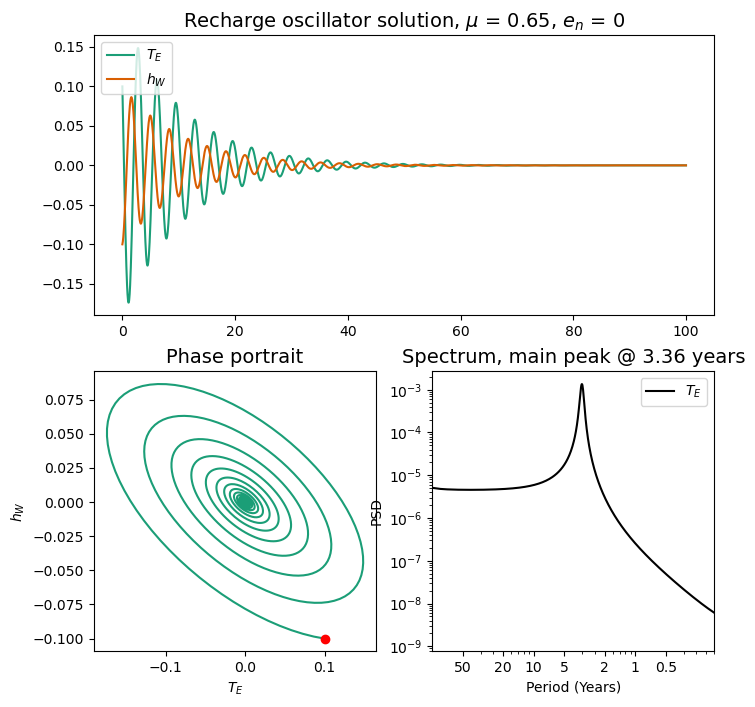

In [22]:
mu, en = 0.65, 0  # set variable parameters
x0 = [[0.1,-0.1]]   # initial conditions
t, x_t = recharge_solver(mu,en)  # solve the system
nt = t.shape[0];  start_time = int(nt/5)  # plot only the last "last_time" steps in case the plot is too dense
recharge_plotter(t, x_t, mu, en, x0, start_time) # plot it

The top panel shows the temporal evolution of our two state variables $T_E$ and $h_W$. The bottom left panel shows a [phase portrait](https://en.wikipedia.org/wiki/Phase_portrait) ($h_W$ as a function of $T_E$ for all values of time $t$). This representation is useful because it can help identify oscillations (closed trajectories), instabilities (outward spirals), stable fixed points (nodes, inward spirals, etc) and a host of other things. Here as in future figures, the red dot marks the initial conditions. One can see that the system undergoes highly damped oscillations, as predicted from the linear sensitivity analysis. The phase portrait illustrates this as an inward spiral that eventually converges to 0 (a state of rest). Verify that the behavior occurs for any $\mu < \mu_c$.

The bottom right panel displays the so-called "[spectral density](https://en.wikipedia.org/wiki/Spectral_density)" (or power spectrum) of the SST. If you are not familiar with this quantity, think of it as an indication of how much energy is contained in a signal at various frequencies (or periods) of oscillation. In this case, it shows a peak at 3.36 years. This means that, although the oscillations are damped, they are quite regular, with a period broadly consistent with that of the real ENSO (3-4 years on average). Not bad for an absurdly simple model!





### What happens right at the critical value $ \mu = 2/3$? 
(note: Python 2 is a little finicky with divisions. "2/3" returns 0 because it thinks you are trying to perform an Euclidean division of integers. Instead, do 2./3, as it will understand that the first number is real, and therefore the fraction makes sense)

ts [0.00000000e+00 4.16701392e-02 8.33402784e-02 ... 4.99916660e+02
 4.99958330e+02 5.00000000e+02]
last_time 1200


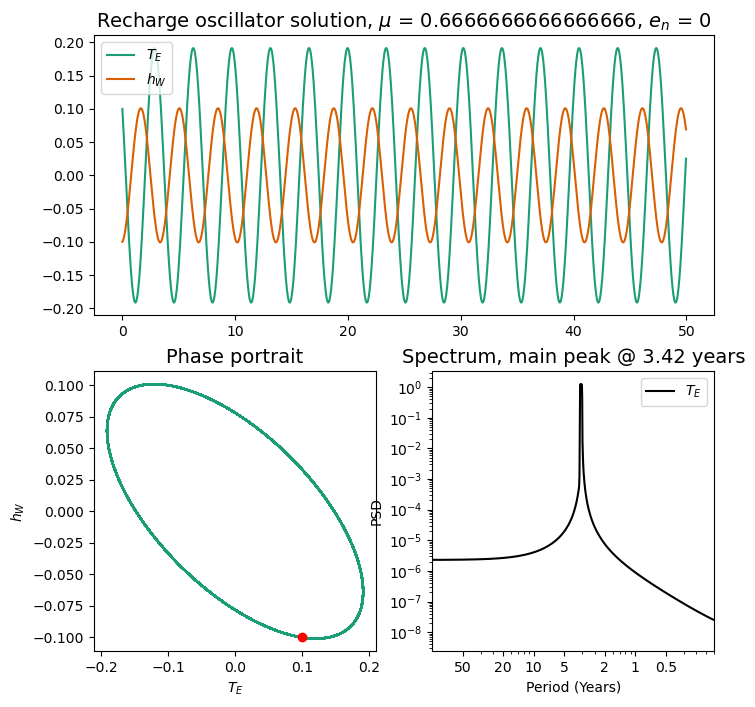

In [20]:
mu, en = 2./3, 0  # set variable parameters
x0 = [[0.1,-0.1]]   # initial conditions
t, x_t = recharge_solver(mu,en)  # solve the system
nt = t.shape[0];  last_time = int(nt/10)
recharge_plotter(t, x_t, mu, en, x0, last_time) # plot it

### Question 1 ### 

Describe the behavior of the system at criticality. 

### Answer 1:

Write your answer here


### What happens for supercritical values $ \mu > 2/3$? 



In [ ]:
# run the system for mu = 0.7, say

### Question 2 ### 

Describe the supercritical behavior of the system. 
### Answer 2:

Write your answer here


## Nonlinear effects

Linear theories are useful when perturbations are small, but they often break down once perturbations grow. Often, nonlinear terms will kick in at that point and will help stabilize the system. One of the strongest nonlinearities in the tropical Pacific ocean-atmosphere system is the fact that subsurface temperatures depend on thermocline depth in a sigmoidal fashion (flat for large values of $|h|$, and linear in between). The essence of this behavior may be incorporated in our toy model by including an extra, cubic term in the SST equation:

$$ \frac{d T_E}{dt} = R T_E + \gamma h_W -e_n (h_W + b T_E)^3 $$

Now, to save myself some coding, it turns out that I have already included this term in the solver. All you need to do to activate it is enter a positive value of $e_n$, say  $e_n = 3$.



ts [0.00000000e+00 4.16701392e-02 8.33402784e-02 ... 4.99916660e+02
 4.99958330e+02 5.00000000e+02]
last_time 2400


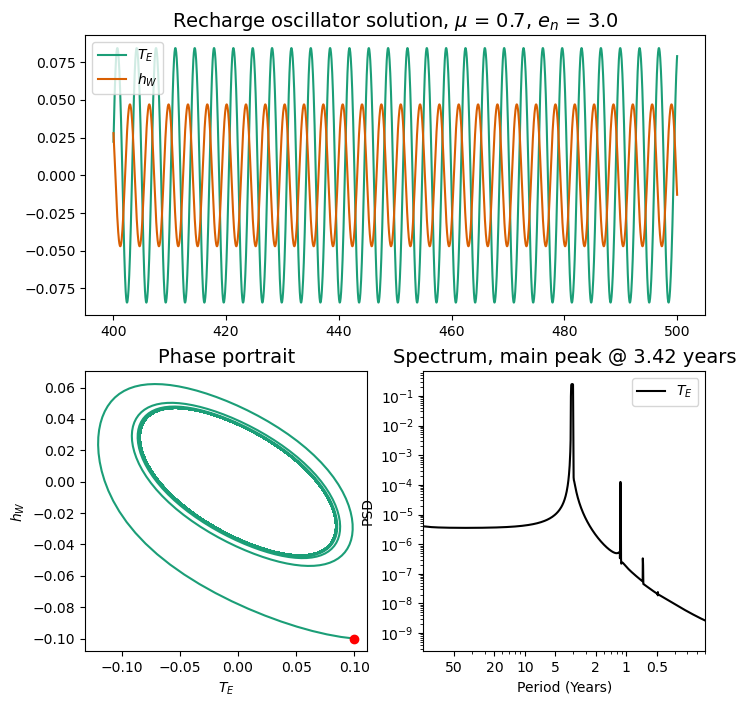

In [17]:
mu, en = 0.7, 3.0  # set variable parameters
x0 = [[0.1,-0.1]]   # initial conditions
t, x_t = recharge_solver(mu,en)  # solve the system
nt = t.shape[0];  last_time = int(nt/5)
recharge_plotter(t, x_t, mu, en, x0, last_time) # plot it

### Question 3.1 ### 

Describe the system's behavior with the inclusion of a nonlinear term, comparing to Question 2. 

### Question 3.2 ### 

Change the values of $e_n$ and $\mu$ and describe qualitatively and quantitatively  what happens, particulary regarding the period of oscillation. 

### Answer 3.1, 3.2:

Write your answers here







##  Frequency entraiment of the recharge oscillator

So far you should have found many combinations of parameters that lead to so-called "self-sustained" oscillations. That is, in a nonlinear regime, the system has the ability to excite itself, and even in the absence of external forcing this oscillation will keep going. There aren't enough variables in this system to create chaos (it turns out that you need at least three), but at least this model contains the basic ingredients for an ENSO-like oscillatory instability. 

As your explorations should have revealed, the period of oscillation is not a particulary robust feature of this model: depending on arbitrary paramter choices, one can get oscillation periods that vary quite a bit. Besides, none of the oscillations actually line up with the calendar year, unlike in reality.

This had lead some investigators to explore the possibility that phase-locking the calendar year (and it some cases chaos) arise because of interaction with the seasonal cycle. The underlying physical mechanism is called "mode locking", and was first described in the 17th century. Dixit Wikipedia:

>*Dutch physicist Christiaan Huygens, the inventor of the pendulum clock, introduced the concept after he noticed, in 1666, that the pendulums of two clocks mounted on a common board had synchronized, and subsequent experiments duplicated this phenomenon. He described this effect as "odd sympathy". The two pendulum clocks synchronized with their pendulums swinging in opposite directions, 180° out of phase, but in phase states can also result. Entrainment occurs because small amounts of energy are transferred between the two systems when they are out of phase in such a way as to produce negative feedback. As they assume a more stable phase relationship, the amount of energy gradually reduces to zero. In the realm of physics, Huygens' observations are related to resonance and the resonant coupling of harmonic oscillators, which also gives rise to sympathetic vibrations.*

You can watch a simple demonstration of it [here](https://www.youtube.com/watch?v=W1TMZASCR-I). If you are curious, here is a [good TED talk about it](https://www.youtube.com/watch?v=IiXaZGZqpVI) (to watch at home)

In Nature, we know that the tropical Pacific is driven periodically by the annual cycle of insolation, which has obvious impacts on temperature.
In the following, we thus add a forcing term $A_f\sin \left ( \frac{2\pi}{P_f} t \right )$ to the $T_E$ equation. $A_f$ is the forcing amplitude, and $P_f$ the forcing period.


In [ ]:
def recharge_deriv((T,h),t, mu, en, Af, Pf, c = 1.0,r= 0.25,alpha = 0.125, b0 = 2.5, gamma = 0.75):
    """Compute the time-derivative of the recharge system system."""
    b = b0*mu # coupling coefficient     
    R = gamma*b-c;  #Bjerknes coefficient
    forcing = Af*np.sin(2*np.pi*t/Pf)
    return [R*T + gamma*h - en*(h + b*T)**3 + forcing, -r*h - alpha*b*T]    
    

def recharge_solver(mu,en,x0, Af=1.0, Pf=6.0,max_time = 3000):  
    """ Solve recharge oscillator ODE system
        mu = effective coupling
        en = strength of nonlinear feedback
        x0 = initial conditions
        Af = forcing amplitude
        Pf = forcing period
    """
    # define time axis
    t = np.linspace(0, max_time, int(4*max_time),endpoint=False)
    # Solve for the trajectories
    x_t = np.asarray([integrate.odeint(recharge_deriv, x0i, t, (mu, en, Af, Pf))
                      for x0i in x0])
    return t, x_t
    
def recharge_plotter(T, h, t, mu, en, Fs, Af=0.0, Pf=6.0):
    """ Plot the output of recharge_solver 
        Fs = sampling frequency    
    """
    # extract output
    ts = t*tscale; nt = t.shape[0]
    last_time = np.round(nt/5.0)
    # obtain spectrum
    f_T, S_T, nu = tsa.multi_taper_psd(T,Fs)
    # compute average period
    DominantPeriod =  "{:4.2f}".format(1.0/f_T[np.argmax(S_T)])  
    # PLOT IT OUT
    plt.close('all')  
    fig = plt.figure(figsize=(8,8))
    # plot traces
    ax1 = plt.subplot2grid((2, 2), (0, 0),colspan = 2)
    hdl = ax1.plot(ts[-last_time:],T[-last_time:],ts[-last_time:],h[-last_time:])
    ax1.legend(hdl,[r'$T_E$',r'$h_W$'],loc = 'upper left')
    ax1.set_title(r'Recharge oscillator solution, $\mu$ = %s, $e_n$ = %s, $A_f=$ %s'%(mu, en, Af),fontsize=14)
    # phase portrait
    ax2 = plt.subplot2grid((2, 2), (1, 0))
    ax2.plot(x_t[0,:,0],x_t[0,:,1])
    ax2.plot(x0[0][0],x0[0][1],'ro')
    ax2.set_xlabel(r'$T_E$'); ax2.set_ylabel(r'$h_W$')
    ax2.set_title("Phase portrait",fontsize=14)
    # 
    ax3 = plt.subplot2grid((2, 2), (1, 1))
    ax3.loglog(f_T,S_T, label=r'$T_E$',color='black')
    ax3.tick_params(axis="both", which="both", bottom="on", top="off",  
                    labelbottom="on", left="on", right="off", labelleft="on",direction="out")  
    #ax3.minorticks_off()
    ax3.legend()
    ax3.set_title(r'T spectrum, main peak @ %s years'%DominantPeriod,fontsize=14)
    ax3.set_xlabel(r'Period (Years)'); ax3.set_xlim([1e-2,6.0])
    ax3.set_ylabel(r'PSD')
    per = [50,20,10,5,2,1]
    xt = 1.0/np.array(per)
    ax3.set_xticks(xt)
    ax3.set_xticklabels(map(str, per))
    

We will drive our oscillator with an annual period ($P_f = 6$, since the time step is 2 months). Let us start with a very weak forcing $A_f = 0.01$.

/Users/jeg/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:40: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


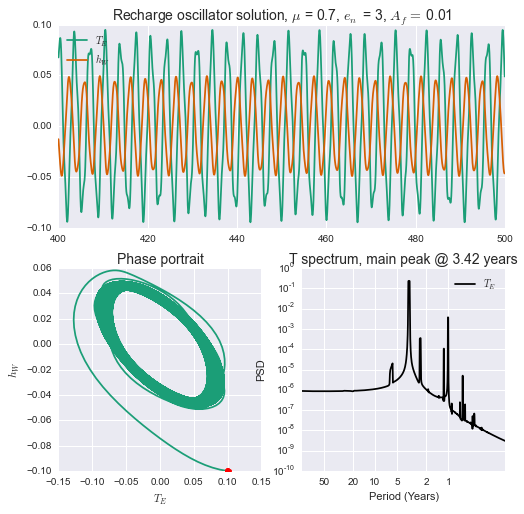

In [ ]:
mu, en = 0.7, 3  # set free oscillator parameters
x0 = np.float64([[.1,-.1]]) # set initial conditions
Af = 0.01 # forcing amplitude
Pf = 6.0  # forcing period (in nondimensional units: 6 = 12 months = 1 year)

# solve system
t, x_t = recharge_solver(mu,en,x0,Af,Pf)
T = x_t[0,:,0]; h = x_t[0,:,1]
ts = t*tscale;
Fs = np.shape(np.where(ts<=1))[1] # get sampling frequency

# PLOT IT
recharge_plotter(T, h ,t, mu, en, Fs, Af)



### Question 4.1 ### 

What happens as you crank up A_f to 0.1, 0.2 or higher? Describe how the period of oscillation changes, as well as the qualitative features of the phase portrait. 

### Answer 4.1:

Write your answers here

### Question 4.2 ### 

Using the cell below, repeat the above experiment with the stronger coupling $\mu = 1.2$. If time allows, play with varing $e_n$ as well. What do you observe? 

### Answer 4.2:

Write your answers here